In [41]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.cm as cm
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib as mpl
from pandas.api.types import is_numeric_dtype
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.patches as patches
import os
from pathlib import Path


def get_contrasting_color(rgb):
    """
    Compute the relative luminance of an RGB color and return a contrasting text color.
    If the background is dark (low luminance), return white; otherwise, return black.
    """
    r, g, b = rgb[:3] if len(rgb) > 3 else rgb
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return "white" if luminance < 0.5 else "black"

colors = ["#7f4a88", "#dfd2e1"]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)

In [42]:
def get_contrasting_color(color):
    try:
        rgb = mpl.colors.to_rgb(color)
        lum = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
        return "black" if lum > 0.5 else "white"
    except:
        return "black"

def generate_barplots(
    datasets: list,
    mode: str,
    method_colors: dict,
    data_dir: str,
    height: float = 0.4,
    alpha: float = 0.8,
    save: bool = True,
    output_path: str = "combined_scores_plot.png",
    scale_metric1: bool = False,
    scale_metric2: bool = False,
    subplot_width: float = 1,
    rank_subplot_width: float = 0.8,
    dl_subplot_width: float = 0.3,
    title_fontsize: int = 7,
    row_fontsize: int = 10,
    data_rename_dict: dict = None,
    method_rename_dict: dict = None,
    pointsize: int = 5,
    bg_color: str = '#e0e0e0',
):

    if not datasets:
        raise ValueError("Dataset list cannot be empty.")
    if not method_colors:
        raise ValueError("Method colors dictionary cannot be empty.")
    
    valid_modes = [
        "Directional_Consistency", "Temporal_Precision", "Negative_Control_Robustness",
        "simulation1", "simulation2", "stability"
    ]
    if mode not in valid_modes:
        raise ValueError(f"Mode must be one of {valid_modes}")


    metric1_dfs, metric2_dfs = {}, {}
    all_methods = set()

    for dataset in datasets:

        if mode == "Directional_Consistency":
            metric1_path = Path(data_dir) / dataset  / "cbdir_df.csv"
            metric2_path = Path(data_dir) / dataset  / "icvcoh_df.csv"
        elif mode == "Temporal_Precision":
            metric1_path = Path(data_dir) / dataset / "cto_df.csv"
            metric2_path = Path(data_dir) / dataset / "spearman_df.csv"
        elif mode == "Negative_Control_Robustness":
            metric1_path = Path(data_dir) / dataset  / "self_transition_df.csv"
            metric2_path = Path(data_dir) / dataset  / "normalized_entropy_df.csv"
        elif mode == "simulation1":
            metric1_path = Path(data_dir) / dataset  / "cosine_similarity_df.csv"
            metric2_path = Path(data_dir) / dataset  / "pearson_df.csv"
        elif mode == "simulation2":
            metric1_path = Path(data_dir) / dataset  / "distance_correlation_df.csv"
            metric2_path = Path(data_dir) / dataset  / "pearson_df.csv"
        elif mode == "stability":
            metric1_path = Path(data_dir) / dataset / "ssd_df.csv"
            metric2_path = Path(data_dir) / dataset  / "sst_df.csv"

        if not metric1_path.exists():
            raise FileNotFoundError(f"{metric1_path} not found.")
        if not metric2_path.exists():
            raise FileNotFoundError(f"{metric2_path} not found.")

        metric1_df = pd.read_csv(metric1_path)
        metric2_df = pd.read_csv(metric2_path)
        metric1_df.iloc[:, 1:] = metric1_df.iloc[:, 1:].astype(np.float64)
        metric2_df.iloc[:, 1:] = metric2_df.iloc[:, 1:].astype(np.float64)

        metric1_dfs[dataset] = metric1_df
        metric2_dfs[dataset] = metric2_df

        mutual = set(metric1_df["Method"]).intersection(metric2_df["Method"])
        metric1_df = metric1_df[metric1_df["Method"].isin(mutual)]
        metric2_df = metric2_df[metric2_df["Method"].isin(mutual)]
        all_methods.update(mutual)

    all_methods = sorted(list(all_methods))


    if method_rename_dict is None:
        method_rename_dict = {}
    display_methods = [method_rename_dict.get(m, m) for m in all_methods]

    updated_colors = {
        method_rename_dict.get(m, m): method_colors.get(m, "#999999") for m in all_methods
    }
    method_colors = updated_colors

    metric1_means, metric1_scores = {m: [] for m in all_methods}, {m: [] for m in all_methods}
    metric2_means, metric2_scores = {m: [] for m in all_methods}, {m: [] for m in all_methods}

    for j, dataset in enumerate(datasets):
        for method in all_methods:
            # Metric 1
            m1_df = metric1_dfs[dataset]
            if method in m1_df["Method"].values:
                vals = m1_df[m1_df["Method"] == method].iloc[0, 1:].to_numpy()
                vals = (vals + 1) / 2 if scale_metric1 else vals
                metric1_scores[method].append(vals)
                metric1_means[method].append(vals.mean())
            else:
                metric1_scores[method].append(np.full(3, np.nan))
                metric1_means[method].append(np.nan)

            # Metric 2
            m2_df = metric2_dfs[dataset]
            if method in m2_df["Method"].values:
                vals = m2_df[m2_df["Method"] == method].iloc[0, 1:].to_numpy()
                vals = (vals + 1) / 2 if scale_metric2 else vals
                metric2_scores[method].append(vals)
                metric2_means[method].append(vals.mean())
            else:
                metric2_scores[method].append(np.full(3, np.nan))
                metric2_means[method].append(np.nan)

    metric1_mean_means = {m: np.nanmean(metric1_means[m]) for m in all_methods}
    metric2_mean_means = {m: np.nanmean(metric2_means[m]) for m in all_methods}

    metric1_rank_series = pd.Series(metric1_mean_means).rank(ascending=False, method="min")
    metric2_rank_series = pd.Series(metric2_mean_means).rank(ascending=False, method="min")
    avg_rank_val = (metric1_rank_series + metric2_rank_series) / 2
    overall_rank_series = avg_rank_val.rank(ascending=True, method="min")

    metric1_ranks = metric1_rank_series.astype(int).to_dict()
    metric2_ranks = metric2_rank_series.astype(int).to_dict()
    overall_ranks = overall_rank_series.astype(int).to_dict()

    all_methods = sorted(all_methods, key=lambda x: overall_ranks.get(x, np.inf), reverse=True)
    display_methods = [method_rename_dict.get(m, m) for m in all_methods]

    sns.set_theme(style="white")
    
    n_datasets = len(datasets)
    n_cols = 1 + (n_datasets + 1) + (n_datasets + 1) + 1 
    
    idx_dl = 0
    idx_m1_start = 1
    idx_m1_end = idx_m1_start + n_datasets - 1
    idx_m1_rank = idx_m1_end + 1
    idx_m2_start = idx_m1_rank + 1
    idx_m2_end = idx_m2_start + n_datasets - 1
    idx_m2_rank = idx_m2_end + 1
    idx_overall = idx_m2_rank + 1
    
    rank_indices = [idx_m1_rank, idx_m2_rank, idx_overall]
    
    width_ratios = []
    for i in range(n_cols):
        if i == idx_dl:
            width_ratios.append(dl_subplot_width)
        elif i in rank_indices:
            width_ratios.append(rank_subplot_width)
        else:
            width_ratios.append(subplot_width)
            
    total_fig_width = sum(width_ratios)


    n_methods = len(all_methods)
    fig_height = max(5, n_methods * 0.2 + 2) 

    fig, axes = plt.subplots(
        1,
        n_cols,
        figsize=(total_fig_width, fig_height),
        gridspec_kw={"wspace": 0.1, "hspace": 0.1, "width_ratios": width_ratios},
    )
    fig.patch.set_facecolor(bg_color)
    
    bar_region_left, bar_region_right = 0.1, 0.9
    bar_region_bottom, bar_region_top = 0.1, 0.9
    fig.subplots_adjust(
        left=bar_region_left, right=bar_region_right,
        bottom=bar_region_bottom, top=bar_region_top,
    )
    
    fig.add_artist(
        Rectangle(
            (bar_region_left, bar_region_bottom),
            bar_region_right - bar_region_left,
            bar_region_top - bar_region_bottom,
            transform=fig.transFigure,
            facecolor="white",
            edgecolor="none",
            zorder=-1,
        )
    )
    for ax in axes:
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)
        ax.set_facecolor("white")

    rank_cmap = plt.cm.Blues
    max_rank_val = max(
        max(metric1_ranks.values()),
        max(metric2_ranks.values()),
        max(overall_ranks.values()),
    )
    
    def get_rank_color(r):
        if max_rank_val <= 1:
            val = 1.0
        else:
            val = 1.0 - (r - 1) / (max_rank_val - 1) * 0.7
        return rank_cmap(val)

    rank_box_alpha = 0.5 

    ax = axes[idx_dl]
    ax.set_ylim(-0.5, len(all_methods) - 0.5)
    ax.set_yticks(range(len(all_methods)))
    ax.set_yticklabels(display_methods, fontsize=row_fontsize)
    ax.set_xticks([])
    ax.set_title("DL", fontsize=title_fontsize, weight="normal")
    
    for j in range(n_datasets):
        ax = axes[idx_m1_start + j]
        for i, method in enumerate(all_methods):
            if not np.isnan(metric1_means[method][j]):
                disp_name = method_rename_dict.get(method, method)
                ax.barh(
                    i,
                    metric1_means[method][j],
                    color=method_colors.get(disp_name, "#999999"),
                    height=height,
                    alpha=alpha,
                    edgecolor="none",
                )
                scores = metric1_scores[method][j]
                ax.scatter(
                    scores,
                    np.full_like(scores, i),
                    color="black",
                    s=pointsize,
                    alpha=0.8,
                    zorder=10,
                    marker="o",
                    edgecolors="black",
                    linewidths=0.5
                )
        ax.set_ylim(-0.5, len(all_methods) - 0.5)
        ax.set_yticks([])
        title_text = data_rename_dict.get(datasets[j], datasets[j]) if data_rename_dict else datasets[j]
        ax.set_title(title_text, fontsize=title_fontsize)
        ax.set_xticks([])

    ax = axes[idx_m1_rank]
    for i, method in enumerate(all_methods):
        if not np.isnan(metric1_mean_means[method]):
            r = metric1_ranks[method]
            color = get_rank_color(r)
            ax.add_patch(
                patches.FancyBboxPatch(
                    (0.36, i - 0.3), 0.25, 0.7,
                    boxstyle="square,pad=0",
                    facecolor=color, 
                    edgecolor="none",
                    alpha=rank_box_alpha
                )
            )
            ax.text(
                0.5, i, str(r),
                ha="center", va="center",
                fontsize=8,
                color="black",
            )
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(all_methods) - 0.5)
    ax.set_yticks([])
    ax.set_title("Rank", fontsize=title_fontsize, weight="normal")
    ax.set_xticks([])
    ax.axis("off")

    # --- 4. Metric 2 Data ---
    for j in range(n_datasets):
        ax = axes[idx_m2_start + j]
        for i, method in enumerate(all_methods):
            if not np.isnan(metric2_means[method][j]):
                disp_name = method_rename_dict.get(method, method)
                ax.barh(
                    i,
                    metric2_means[method][j],
                    color=method_colors.get(disp_name, "#999999"),
                    height=height,
                    alpha=alpha,
                    edgecolor="none",
                )
                scores = metric2_scores[method][j]
                ax.scatter(
                    scores,
                    np.full_like(scores, i),
                    color="black",
                    s=pointsize,
                    alpha=0.8,
                    zorder=10,
                    marker="o",
                    edgecolors="black",
                    linewidths=0.5
                )
        ax.set_ylim(-0.5, len(all_methods) - 0.5)
        ax.set_yticks([])
        title_text = data_rename_dict.get(datasets[j], datasets[j]) if data_rename_dict else datasets[j]
        ax.set_title(title_text, fontsize=title_fontsize)
        ax.set_xticks([])

    # --- 5. Metric 2 Rank ---
    ax = axes[idx_m2_rank]
    for i, method in enumerate(all_methods):
        if not np.isnan(metric2_mean_means[method]):
            r = metric2_ranks[method]
            color = get_rank_color(r)
            ax.add_patch(
                patches.FancyBboxPatch(
                    (0.36, i - 0.3), 0.25, 0.7,
                    boxstyle="square,pad=0",
                    facecolor=color, 
                    edgecolor="none",
                    alpha=rank_box_alpha
                )
            )
            ax.text(
                0.5, i, str(r),
                ha="center", va="center",
                fontsize=8,
                color="black",
            )
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(all_methods) - 0.5)
    ax.set_yticks([])
    ax.set_title("Rank", fontsize=title_fontsize, weight="normal")
    ax.set_xticks([])
    ax.axis("off")

    # --- 6. Overall Rank ---
    ax = axes[idx_overall]
    for i, method in enumerate(all_methods):
        if not np.isnan(overall_ranks[method]):
            r = overall_ranks[method]
            color = get_rank_color(r)
            ax.add_patch(
                patches.FancyBboxPatch(
                    (0.36, i - 0.3), 0.25, 0.7,
                    boxstyle="square,pad=0",
                    facecolor=color, 
                    edgecolor="none",
                    alpha=rank_box_alpha
                )
            )
            ax.text(
                0.5, i, str(r),
                ha="center", va="center",
                fontsize=8,
                color="black",
            )
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(all_methods) - 0.5)
    ax.set_yticks([])
    ax.set_title("Rank", fontsize=title_fontsize, weight="normal")
    ax.set_xticks([])
    ax.axis("off")
    
    bbox = ax.get_position()
    overall_center_x = (bbox.x0 + bbox.x1) / 2

    
    axes[idx_m2_start].axvline(
        x=0, ymin=0, ymax=1,
        color="gray", linestyle="--", linewidth=1.5, clip_on=False
    )
    
    axes[idx_overall].axvline(
        x=0, ymin=0, ymax=1,
        color="gray", linestyle="--", linewidth=1.5, clip_on=False
    )

    if mode == "Directional_Consistency":
        title = ["CBDir (scaled)", "ICVCoh"]
    elif mode == "Temporal_Precision":
        title = ["CTO", "Spearman (scaled)"]
    elif mode == "Negative_Control_Robustness":
        title = ["Self Transition", "Normalized Entropy"]
    elif mode == "simulation1":
        title = ["Cosine Similarity", "Pearson (scaled)"]
    elif mode == "simulation2":
        title = ["Distance Correlation", "Pearson Correlation"]
    elif mode == "stability":
        title = ["SSD", "SST"]
    else:
        raise ValueError("Invalid mode.")
    
    def get_axes_center(start_idx, end_idx):
        bbox_start = axes[start_idx].get_position()
        bbox_end = axes[end_idx].get_position()
        return (bbox_start.x0 + bbox_end.x1) / 2

    center_m1 = get_axes_center(idx_m1_start, idx_m1_rank)
    center_m2 = get_axes_center(idx_m2_start, idx_m2_rank)
    
    plt.text(center_m1, 0.95, title[0], transform=fig.transFigure, fontsize=10, weight="normal", ha="center")
    plt.text(center_m2, 0.95, title[1], transform=fig.transFigure, fontsize=10, weight="normal", ha="center")
    plt.text(overall_center_x, 0.95, "Overall", transform=fig.transFigure, fontsize=10, weight="normal", ha="center")

    if save:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
    else:
        plt.show()

    plt.close()

In [43]:
newmethods = {
        'velocyto': "Velocyto",
        'scvelo_dyn': "scVelo (dyn)",
        'scvelo_stc': "scVelo (stc)",
        'veloae': "VeloAE",
        'dynamo_m1': "Dynamo (m1)",
        'unitvelo_ind': "UniTVelo (ind)",
        'unitvelo_uni': "UniTVelo (uni)",
        'velovae_std': "VeloVAE (std)",
        'velovae_fullvb': "VeloVAE (Full VB)",
        'deepvelo': "DeepVelo",
        'celldancer': "cellDancer",
        'pyrovelocity_m1': "Pyro-Velocity (m1)",
        'pyrovelocity_m2': "Pyro-Velocity (m2)",
        'kvelo': "κ-velo",
        'velovi': "veloVI",
        'cell2fate': "cell2fate",
        'sdevelo': "SDEvelo",
        'svelvetvae': "SvelvetVAE",
        'latentvelo_std': "LatentVelo (std)",
        'tivelo_std': "TIVelo (std)",
        'tivelo_simple': "TIVelo (simple)",
        'sctour_mse': "scTour (MSE)",
        'sctour_nb': "scTour (NB)",
        'sctour_zinb': "scTour (ZINB)",
        'velvetvae': "VelvetVAE",
        'graphvelo_std': "GraphVelo (std)"}

In [44]:
method_colors = {
    'velocyto': "#6587AB",
    'scvelo_dyn': "#76B7B2",
    'scvelo_stc': "#92CB8A",
    'veloae': "#F6A24F",
    'dynamo_m1': "#FF9DA7",
    'unitvelo_ind': "#9C755F",
    'unitvelo_uni': "#DC6F71",
    'velovae_std': "#C6A11B",
    'velovae_fullvb': "#4F5CD5",
    'deepvelo': "#B07AA1",
    'celldancer': "#2E91E5",
    'pyrovelocity_m1': "#1EB754",
    'pyrovelocity_m2': "#FFBE7A",
    'kvelo': "#A05195",
    'velovi': "#B5BD61",
    'cell2fate': "#AD2513",
    'sdevelo': "#1F3E80",
    'svelvetvae': "#F6D55C",
    'latentvelo_std': "#6ACCBC",
    'tivelo_std': "#694D34",
    'tivelo_simple': "#F39B7F",
    'sctour_mse': "#8A89A6",
    'sctour_nb': "#A7D9D3",
    'sctour_zinb': "#F97F05",
    'graphvelo_std': "#0AC7DC"
}

In [45]:
datasets = ["data21", 
            "data22", 
            "data23", 
            "data24",
            "data25",
            "data26"]
generate_barplots(datasets, 
                    "simulation2",
                    method_colors,
                    alpha = 0.7, 
                    subplot_width=1,
                    scale_metric2=True,
                    title_fontsize=8,
                    row_fontsize=8,
                    pointsize=3,
                    data_dir="./", 
                    data_rename_dict={
                        "data21": "ODE 100",
                        "data22": "ODE 500",
                        "data23": "SDE 100",
                        "data24": "SDE 500",
                        "data25": "Dyngen (l)",
                        "data26": "Dyngen (b)"
                    },
                    method_rename_dict=newmethods,
                    save=True, 
                    output_path="simu_rank.png")

/tmp/ipykernel_94724/2254882998.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_94724/2254882998.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['DL','Non-DL'],fontsize=12)


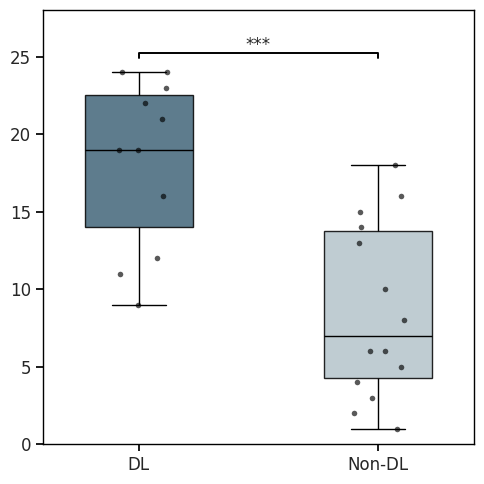

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

df = pd.read_csv('simu_rank.csv')
df["DL"] = df["DL"].astype(str)
df["DL"] = pd.Categorical(df["DL"], categories=["1", "0"], ordered=True)

plt.figure(figsize=(5, 5))
sns.set_style("white")

group_colors = {
    '1':'#426579',
    '0':"#B4C3CB"
}

ax = sns.boxplot(
    x="DL",
    y="rank",
    data=df,
    width=0.45,
    linewidth=1.6,
    saturation=1,
    showfliers=False,
    palette=group_colors,
    boxprops={'alpha': 0.85, 'edgecolor': 'black','linewidth': 1.0},
    medianprops={'color': 'black', 'linewidth': 1.0},
    whiskerprops={'color': 'black', 'linewidth': 1.0},
    capprops={'color': 'black', 'linewidth': 1.0},
)


sns.stripplot(
    x="DL",
    y="rank",
    data=df,
    color="black",
    size=4,
    jitter=0.12,
    alpha=0.65
)

plt.xlabel("", fontsize=13)
plt.ylabel("", fontsize=13)
plt.title("", fontsize=14)


group1 = df[df["DL"] == "1"]["rank"]
group0 = df[df["DL"] == "0"]["rank"]

stat, p = mannwhitneyu(group1, group0, alternative="two-sided")
ax.set_xticklabels(['DL','Non-DL'],fontsize=12)
lims = [0, 28]
plt.ylim(lims)
y_ticks = np.arange(np.floor(lims[0]), np.ceil(lims[1]) + 1, 5)
plt.yticks(y_ticks, fontsize=12)

def p_to_star(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return "n.s."

star = p_to_star(p)


y_max = df["rank"].max()
line_y = y_max + (y_max * 0.05)
text_y = y_max + (y_max * 0.06)

x1, x2 = 0, 1

plt.plot(
    [x1, x1, x2, x2],
    [line_y - 0.3, line_y, line_y, line_y - 0.3],
    lw=1.4,
    color="black"
)

plt.text((x1 + x2) / 2, text_y, star, ha="center", fontsize=12)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)


ax.set_xlim(-0.4, 1.4)

plt.tight_layout()
plt.savefig(f"DL_simu.png", bbox_inches="tight", dpi=300)
plt.show()


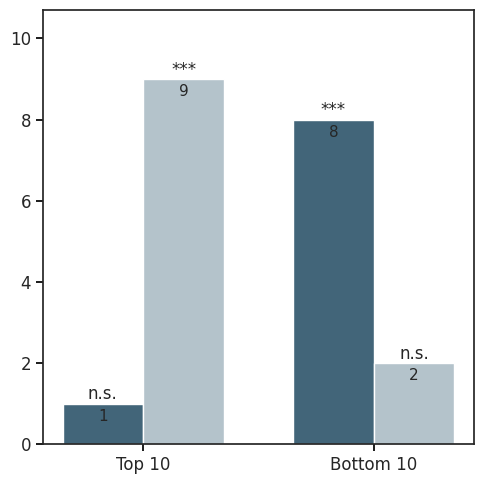

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import hypergeom


top_k = 10


is_gd = (df["DL"] == "1")
is_notgd = (df["DL"] == "0")


df_top = df.nsmallest(top_k, "rank")
gd_top = is_gd.loc[df_top.index].sum()
notgd_top = is_notgd.loc[df_top.index].sum()


df_bottom = df.nlargest(top_k, "rank")
gd_bottom = is_gd.loc[df_bottom.index].sum()
notgd_bottom = is_notgd.loc[df_bottom.index].sum()


def hyper_p(df, group_mask, df_sub):
    N = len(df)
    K = group_mask.sum()
    n = len(df_sub)
    k = group_mask.loc[df_sub.index].sum()
    return hypergeom.sf(k - 1, N, K, n)


p_top_gd = hyper_p(df, is_gd, df_top)
p_top_notgd = hyper_p(df, is_notgd, df_top)
p_bottom_gd = hyper_p(df, is_gd, df_bottom)
p_bottom_notgd = hyper_p(df, is_notgd, df_bottom)


def p_to_star(p):
    if p < 0.01: return "***"
    elif p < 0.05: return "**"
    elif p < 0.1: return "*"
    return "n.s."

stars = [
    p_to_star(p_top_gd),
    p_to_star(p_top_notgd),
    p_to_star(p_bottom_gd),
    p_to_star(p_bottom_notgd)
]


labels = ["Top 10", "Bottom 10"]
gd_counts = [gd_top, gd_bottom]
notgd_counts = [notgd_top, notgd_bottom]

x = np.arange(len(labels))       # [0, 1]
width = 0.35                     # bar width


plt.figure(figsize=(5, 5))

bar1 = plt.bar(x - width/2, gd_counts, width, label="DL", color= '#426579')
bar2 = plt.bar(x + width/2, notgd_counts, width, label="non-DL", color='#B4C3CB')


def annotate_bar(bar, star_text):
    """在柱子上添加 count 数字和星号"""
    for rect, star in zip(bar, star_text):
        height = rect.get_height()

        plt.text(
            rect.get_x() + rect.get_width() / 2,
            height - 0.5,
            f"{int(height)}",
            ha="center", va="bottom", fontsize=11
        )

        plt.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.01,
            star,
            ha="center", va="bottom", fontsize=12
        )

annotate_bar(bar1, stars[:2])     # Top10-GD, Top10-nonGD
annotate_bar(bar2, stars[2:])     # Bottom10-GD, Bottom10-nonGD

# ============================

plt.xticks(x, labels, fontsize=12)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)
# plt.legend()

y_ticks = np.arange(0, 11, 2)
plt.yticks(y_ticks, fontsize=12)
plt.ylim(0.0, 10.5 + 0.2)

plt.tight_layout()
plt.savefig(f"simu_enrich.png", bbox_inches="tight", dpi=300)
plt.show()


/tmp/ipykernel_94724/2593773262.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_94724/2593773262.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['DL','Non-DL'],fontsize=12)


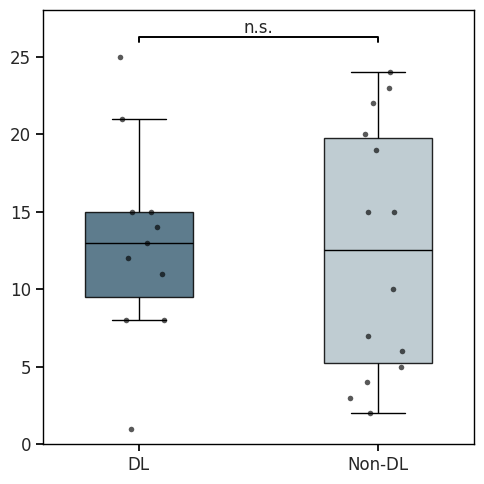

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


df = pd.read_csv('simu_rank.csv')
df["DL"] = df["DL"].astype(str)
df["DL"] = pd.Categorical(df["DL"], categories=["1", "0"], ordered=True)

plt.figure(figsize=(5, 5))
sns.set_style("white")

group_colors = {
    '1':'#426579',
    '0':"#B4C3CB"
}

ax = sns.boxplot(
    x="DL",
    y="real",
    data=df,
    width=0.45,
    linewidth=1.6,
    saturation=1,
    showfliers=False,
    palette=group_colors,
    boxprops={'alpha': 0.85, 'edgecolor': 'black','linewidth': 1.0},
    medianprops={'color': 'black', 'linewidth': 1.0},
    whiskerprops={'color': 'black', 'linewidth': 1.0},
    capprops={'color': 'black', 'linewidth': 1.0},
)


sns.stripplot(
    x="DL",
    y="real",
    data=df,
    color="black",
    size=4,
    jitter=0.12,
    alpha=0.65
)

plt.xlabel("", fontsize=13)
plt.ylabel("", fontsize=13)
plt.title("", fontsize=14)


group1 = df[df["DL"] == "1"]["real"]
group0 = df[df["DL"] == "0"]["real"]

stat, p = mannwhitneyu(group1, group0, alternative="two-sided")
ax.set_xticklabels(['DL','Non-DL'],fontsize=12)
lims = [0, 28]
plt.ylim(lims)
y_ticks = np.arange(np.floor(lims[0]), np.ceil(lims[1]) + 1, 5)
plt.yticks(y_ticks, fontsize=12)

def p_to_star(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return "n.s."

star = p_to_star(p)


y_max = df["real"].max()
line_y = y_max + (y_max * 0.05)
text_y = y_max + (y_max * 0.06)

x1, x2 = 0, 1

plt.plot(
    [x1, x1, x2, x2],
    [line_y - 0.3, line_y, line_y, line_y - 0.3],
    lw=1.4,
    color="black"
)

plt.text((x1 + x2) / 2, text_y, star, ha="center", fontsize=12)


ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)


ax.set_xlim(-0.4, 1.4)

plt.tight_layout()
plt.savefig(f"DL_real.png", bbox_inches="tight", dpi=300)
plt.show()


In [49]:
newname_colors = {
    "Velocyto": "#6587AB",
    "scVelo (dyn)": "#76B7B2",
    "scVelo (stc)": "#92CB8A",
    "VeloAE": "#F6A24F",
    "Dynamo (m1)": "#FF9DA7",
    "Pyro-Velocity (m1)": "#1EB754",
    "Pyro-Velocity (m2)": "#FFBE7A",
    "UniTVelo (uni)": "#DC6F71",
    "UniTVelo (ind)": "#9C755F",
    "VeloVAE (std)": "#C6A11B",
    "VeloVAE (Full VB)": "#4F5CD5",
    "κ-velo": "#A05195",
    "cellDancer": "#2E91E5",
    "veloVI": "#B5BD61",
    "LatentVelo (std)": "#6ACCBC",
    "scTour (MSE)": "#8A89A6",
    "scTour (NB)": "#A7D9D3",
    "scTour (ZINB)": "#F97F05",
    "DeepVelo": "#B07AA1",
    "SDEvelo": "#1F3E80",
    "SvelvetVAE": "#F6D55C",
    "cell2fate": "#AD2513",
    "TIVelo (std)": "#694D34",
    "TIVelo (simple)": "#F39B7F",
    "GraphVelo (std)": "#0AC7DC"
}

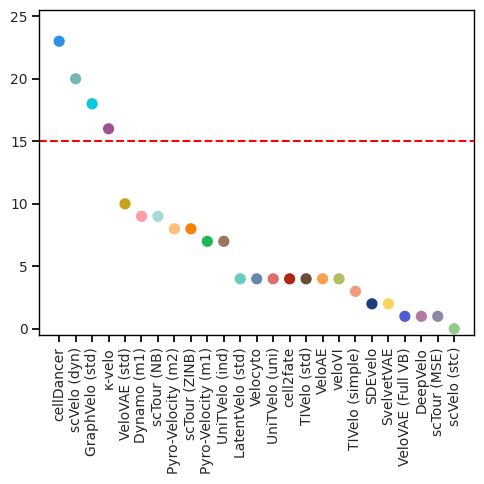

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('simu_rank.csv')

sns.set_style("white")

df["rank_diff"] = (df["rank"] - df["real"]).abs()


df = df.sort_values("rank_diff", ascending=False).reset_index(drop=True)


plt.figure(figsize=(5, 5))

colors = df["Method"].map(newname_colors)

plt.scatter(
    df["Method"],        
    df["rank_diff"],     
    s=50,
    color=colors
)


plt.xlabel("", fontsize=12)
plt.ylabel("", fontsize=12)

plt.xticks(rotation=90, ha="center", fontsize=10)
plt.yticks(fontsize=10)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)
plt.axhline(
    y=15,
    linestyle="--",
    linewidth=1.5,
    color="red"
)
plt.ylim(-0.5, 25.5)
plt.tight_layout()
plt.savefig("simu_diff.png", bbox_inches="tight", dpi=300)
plt.show()


Spearman ρ = 0.664, p = 0.00103


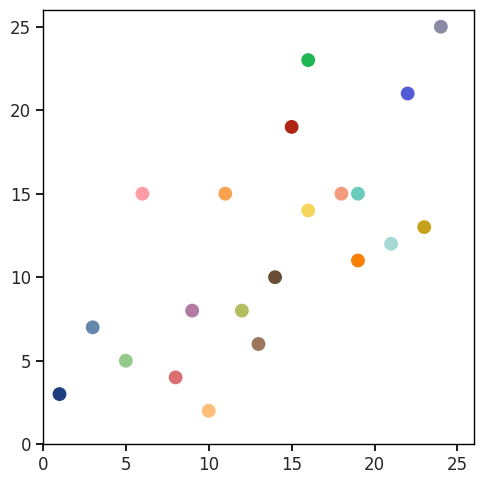

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

df = pd.read_csv('simu_rank.csv')

sns.set_style("white")

remove_methods = [
    "scVelo (dyn)",
    "GraphVelo (std)",
    "cellDancer",
]

df_filtered = df[~df["Method"].str.contains("-velo")]

df_filtered = df_filtered[~df_filtered["Method"].isin(remove_methods)]

rho, pval = spearmanr(df_filtered["rank"], df_filtered["real"])
print(f"Spearman ρ = {rho:.3f}, p = {pval:.3g}")

plt.figure(figsize=(5, 5))
colors = df_filtered["Method"].map(newname_colors)
plt.scatter(df_filtered["rank"], df_filtered["real"], s=80, color=colors)

plt.xlabel("", fontsize=12)
plt.ylabel("", fontsize=12)

# for _, row in df_filtered.iterrows():
#     plt.text(row["rank"] + 0.2,
#              row["real"] + 0.2,
#              row["Method"],
#              fontsize=10)

lims = [0, 26]
plt.xlim(lims)
plt.ylim(lims)

# ticks
x_ticks = np.arange(np.floor(lims[0]), np.ceil(lims[1]) + 1, 5)
y_ticks = np.arange(np.floor(lims[0]), np.ceil(lims[1]) + 1, 5)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)

# spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tick_params(
    axis='both',
    which='both',
    direction='out',
    length=5,
    color='black',
    top=False, right=False,
    bottom=True, left=True
)

plt.tight_layout()
plt.savefig("simu_rank_real_filtered.png",bbox_inches="tight", dpi=300)
plt.show()
